## Code to Chapter 6 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1CIIZ4cGrO7hX1tvby3K-nr4A5qUMaO7P?usp=sharing)

## Building a Langchain App with RDKit Integrations
This notebook demonstrates how to build intelligent chemical analysis applications by combining:
- **LangChain**: Framework for developing applications with language models
- **RDKit**: Open-source cheminformatics toolkit for molecular analysis
- **OpenAI GPT Models**: For natural language understanding and reasoning

### Learning Objectives
- Compare different LLM approaches (vanilla vs augmented with tools)
- Understand how to create custom LangChain tools
- Learn to build retrieval-augmented generation (RAG) systems
- Explore agent architectures for scientific applications

We will address the following queries using RDKit:

1. **Determining Molecular Formula**: We start by examining the provided SMILES notation and use RDKit to calculate its molecular formula. The question at hand is, "What is the formula of this compound?"

2. **Calculate Molecular Weight**: We'll need to calculate the exact molecular weight of the molecule.

3. **Generating a 2D Representation**: RDKit allows us to visualize chemical structures in two dimensions. We will employ RDKit to create a 2D representation of the given SMILES notation and complete the query, "Can you draw a 2D representation of this compound?"

4. **Creating a 3D Visualization**: Taking it a step further, we utilize RDKit to generate a 3D representation of the molecule described by the SMILES notation. We will answer the query, "Can you provide a 3D visualization of this compound?"

### Approaches:
- **Traditional Approach**: General LLM + Chemical Tools (ChemCrow, Cactus)
- **Specialized Approach**: Chemistry-Trained LLM (LLM4Chem)

To accomplish these tasks, we will employ various techniques and resources:

- **Strategies 1a & 1b: `ChemCrow` and `Cactus` Libraries**: We'll make use of the ChemCrow library, a Generative AI cheminformatics python package.

- **Strategy 1c: `LlaSMol-Llama2-7B` Large Language Model**: We'll make use of the specialized chemistry Large Language Model.

- [**Strategy 2: LLM (GPT3.5 + GPT4o) Integration**](#strategy_2): We will leverage the capabilities of GPT3.5 and GPT-4o, a state-of-the-art language models, to answer the questions and display results.

- [**Strategy 3: LCEL Chain (GPT3.5 + GPT4o) Integration**](#strategy_3): We will leverage using LangChain chains, including prompting.

- [**Strategy 4: Langchain + Custom Function Development**](#strategy_4): We will develop our own custom functions, dedicated to complete the queries of our interest.

- [**Strategy 5: Langchain + RDKit Documentation**](#strategy_5): We will explore Langchain agents to generate and run code snippets based on extracted RDKit documentation.

By the end of this notebook, we aim to have a fully functional Langchain application with RDKit integrations that can answer chemical-related queries with ease.

***Disclaimer:** Notebook results may vary slightly with each execution.*

## Installing Required Packages

First, we install all necessary dependencies. Note the specific version pinning
to ensure reproducibility across different environments.

### Package Explanations:
- **rdkit**: Core cheminformatics library for molecular analysis
- **langchain**: Main framework for building LLM applications  
- **langchain_openai**: OpenAI integration for LangChain
- **py3Dmol**: 3D molecular visualization in Jupyter notebooks
- **faiss-cpu**: Vector similarity search for RAG implementation

In [ ]:
!pip install -q numpy==1.26.4
!pip install -q rdkit==2023.9.6 langchain langchain_openai langchainhub langchain_experimental langchain_community langsmith py3Dmol faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5

In [ ]:
!pip freeze | grep "lang\|openai\|rdkit\|faiss\|numpy"

faiss-cpu==1.11.0.post1
google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.2
langchain==0.3.26
langchain-community==0.3.27
langchain-core==0.3.69
langchain-experimental==0.3.4
langchain-openai==0.3.28
langchain-text-splitters==0.3.8
langchainhub==0.1.21
langcodes==3.5.0
langsmith==0.4.6
language_data==1.3.0
libclang==18.1.1
numpy==1.26.4
openai==1.96.1
rdkit==2023.9.6


In [ ]:
import logging

logging.getLogger().setLevel(logging.CRITICAL)

In [ ]:
from google.colab import userdata
import os


# Set OpenAI API key from Google Colab's user environment or default
def set_api_keys(
    default_openai_key: str = "YOUR_API_KEY", default_tavily_key: str = "YOUR_API_KEY"
) -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""

    os.environ["OPENAI_API_KEY"] = (
        userdata.get("LC4LS_OPENAI_API_KEY") or default_openai_key
    )


set_api_keys()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "lc4ls-ch6-chemical-queries"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")

## OpenAI Handler Class

This utility class simplifies working with different OpenAI models and provides
consistent configuration across our experiments.

In [ ]:
import os
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.tracers.stdout import ConsoleCallbackHandler


class OpenAIHandler:
    """
    Centralized handler for OpenAI model interactions with consistent configuration.

    This class encapsulates all OpenAI-related setup and provides methods for:
    - Chat model initialization with different configurations
    - Embedding model setup for vector operations
    - LCEL chain creation for structured prompting
    """

    def __init__(
        self,
        api_key=None,
        model="gpt-3.5-turbo",
        embedding_model="text-embedding-3-large",
        verbose=True,
        temperature=0,
        callback=False,
    ):
        """
        Initialize OpenAI handler with specified configuration.

        Args:
            api_key: OpenAI API key (uses environment variable if None)
            model: Chat model to use (e.g., 'gpt-3.5-turbo', 'gpt-4o-mini')
            embedding_model: Model for generating embeddings
            verbose: Whether to enable verbose logging
            temperature: Sampling temperature (0 = deterministic, 1 = creative)
            callback: Whether to enable console callback for debugging
        """
        self.api_key = api_key or os.getenv("OPENAI_API_KEY")
        self.model_name = model
        self.embedding_model = embedding_model
        self.verbose = verbose
        self.temperature = temperature
        self.callback = callback
        self.model = self._initialize_chat_openai()

    def _initialize_chat_openai(self):
        """
        Initialize ChatOpenAI instance with appropriate configuration.

        Returns:
            ChatOpenAI: Configured chat model instance
        """
        # Enable console callbacks for debugging if requested
        if self.callback:
            return ChatOpenAI(
                temperature=self.temperature,
                openai_api_key=self.api_key,
                verbose=self.verbose,
                model=self.model_name,
            ).with_config({"callbacks": [ConsoleCallbackHandler()]})

        # Special handling for o3-mini model which requires temperature=1
        if self.model_name == "o3-mini":
            self.temperature = 1

        return ChatOpenAI(
            temperature=self.temperature,
            openai_api_key=self.api_key,
            verbose=self.verbose,
            model=self.model_name,
        )

    def initialize_openai_embeddings(self):
        """
        Create OpenAI embeddings instance for vector operations.

        Returns:
            OpenAIEmbeddings: Configured embeddings model
        """
        return OpenAIEmbeddings(model=self.embedding_model, openai_api_key=self.api_key)

    def run_lcel_chain(self, template=None):
        """
        Create an LCEL (LangChain Expression Language) chain with custom template.

        Args:
            template: Custom prompt template (uses default chemistry template if None)

        Returns:
            Chain: Configured LCEL chain ready for execution
        """
        # Default template optimized for chemistry questions
        template = (
            template
            or """
            You are a world-class specialist in chemistry.
            Return only the final answer. Think step by step.
            Question: {question}
            Answer: Let's think step by step.
        """
        )
        prompt = ChatPromptTemplate.from_template(template)
        chain = prompt | self.model  # LCEL syntax for chaining prompt and model
        return chain


def create_vector_db(data, embeddings):
    """
    Create a FAISS vector database from documents for similarity search.

    This function is essential for RAG (Retrieval-Augmented Generation) systems,
    allowing us to find relevant documentation based on semantic similarity.

    Args:
        data (list): List of Document objects to index
        embeddings: Embeddings model for vectorization

    Returns:
        FAISS: Vector database ready for similarity search
    """
    return FAISS.from_documents(data, embeddings)

## Test Compound and Query Setup

### Target Molecule: Aspirin
We'll use aspirin (acetylsalicylic acid) as our test compound:
- **SMILES notation**: `CC(=O)OC1=CC=CC=C1C(=O)O`
- **Common name**: Aspirin
- **IUPAC name**: 2-(acetyloxy)benzoic acid
- **Molecular formula**: C₉H₈O₄
- **Molecular weight**: 180.16 g/mol

### Why This Compound?
Aspirin is an excellent test case because:
1. It's a well-known pharmaceutical compound
2. Has a moderate complexity suitable for testing
3. Contains multiple functional groups (ester, carboxylic acid, aromatic ring)
4. Results can be easily verified against known databases

In [ ]:
# Queries
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
query_1 = f"What is the formula of {smiles}?"
query_2 = f"What is the molecular mass of {smiles}"
query_3 = f"Draw 2D representation of {smiles}?"
query_4 = f"Draw 3D representation of {smiles}?"

Expected Results:
- **Molecular Formula**: C₉H₈O₄
- **Molecular Weight**: ~180.16 g/mol
- **Structure**: Contains acetyl ester and carboxylic acid functional groups

In [ ]:
results = {f"query_{q+1}": {} for q in range(4)}

### Reference:
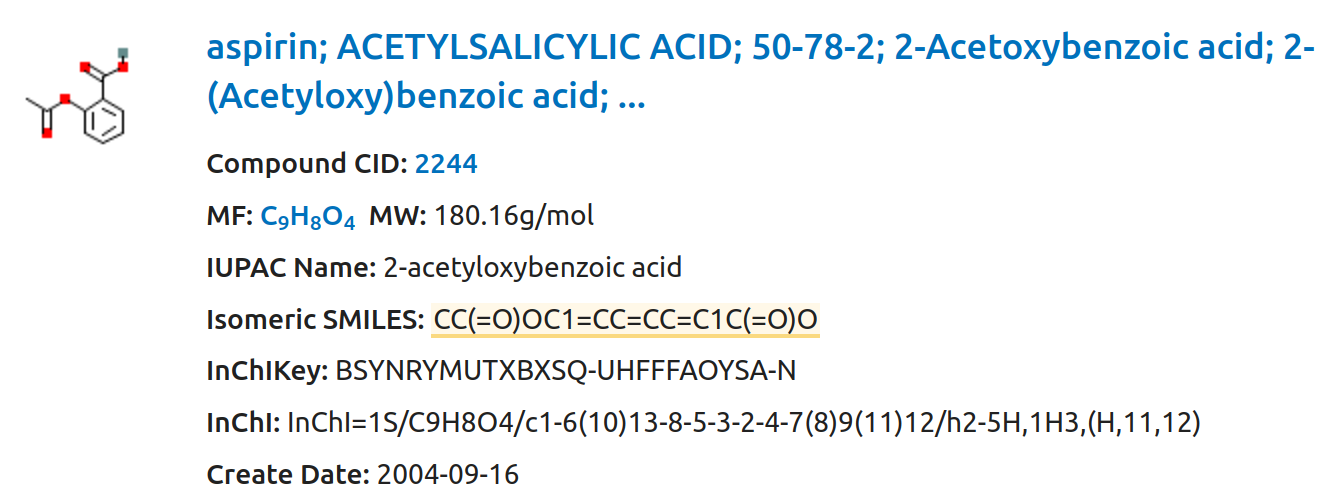

For verification purposes, you can check the compound details at:
[PubChem Entry for Aspirin](https://pubchem.ncbi.nlm.nih.gov/#query=CC(%3DO)OC1%3DCC%3DCC%3DC1C(%3DO)O)


## Strategy 2: Vanilla LLM Approach (GPT-3.5-turbo + GPT-4o-mini)<a class="anchor" id="strategy_2"></a>

Let's start by testing how well different LLMs can handle chemistry questions
without any specialized tools or knowledge. This establishes our baseline.

### Why This Usually Fails:
- LLMs are trained on text, not molecular calculations
- No access to cheminformatics libraries
- Can't perform precise numerical calculations
- Can't generate actual visualizations

In [ ]:
# Specifying LLM
model = "gpt-3.5-turbo"
openai_handler = OpenAIHandler(model=model, verbose=True)

For illustration purposes, we'll set `verbose=True`. For usage purposes, you may set `verbose` as `False`

In [ ]:
results["query_1"]["llm_only_a"] = openai_handler.model.invoke(query_1).content
results["query_1"]["llm_only_a"]

'The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C12H10O4.'

In [ ]:
results["query_2"]["llm_only_a"] = openai_handler.model.invoke(query_2).content
results["query_2"]["llm_only_a"]

'The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 180.16 g/mol.'

In [ ]:
results["query_3"]["llm_only_a"] = openai_handler.model.invoke(query_3).content
results["query_3"]["llm_only_a"]

"I'm sorry, I cannot draw chemical structures. However, I can describe the structure to you. The 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O is a molecule with two carbon atoms connected by a double bond, one of which is also connected to an oxygen atom with a double bond. The carbon atom on the right is connected to an oxygen atom and a carbon atom with a double bond, which is in turn connected to a benzene ring. The benzene ring has alternating single and double bonds between carbon atoms."

In [ ]:
results["query_4"]["llm_only_a"] = openai_handler.model.invoke(query_4).content
results["query_4"]["llm_only_a"]

"I'm sorry, I am not able to draw images. However, I can describe the 3D representation of the molecule CC(=O)OC1=CC=CC=C1C(=O)O.\n\nIn the 3D representation, the molecule would have a central carbon atom bonded to two oxygen atoms on either side. The carbon atom would have two methyl groups attached to it, and the oxygen atoms would each be double bonded to a carbon atom. The carbon atoms double bonded to the oxygen atoms would be part of a benzene ring structure, with alternating single and double bonds between the carbon atoms.\n\nOverall, the molecule would have a linear shape with the benzene ring structure extending outwards from the central carbon atom."

In [ ]:
# Specifying LLM
model = "gpt-4o-mini"
openai_handler = OpenAIHandler(model=model, verbose=True)

In [ ]:
results["query_1"]["llm_only_b"] = openai_handler.model.invoke(query_1).content
results["query_1"]["llm_only_b"]

"The compound you provided, CC(=O)OC1=CC=CC=C1C(=O)O, can be broken down into its components to determine its molecular formula.\n\n1. **CC(=O)** indicates an acetyl group (C2H3O).\n2. **OC1=CC=CC=C1** indicates a phenyl ring (C6H5) with an ether linkage to the acetyl group.\n3. **C(=O)O** indicates a carboxylic acid group (COOH).\n\nNow, let's combine these components:\n\n- The acetyl group contributes: C2H3O\n- The phenyl ring contributes: C6H5\n- The carboxylic acid contributes: C1H1O2\n\nNow, let's add them up:\n\n- Carbon (C): 2 (from acetyl) + 6 (from phenyl) + 1 (from carboxylic acid) = 9\n- Hydrogen (H): 3 (from acetyl) + 5 (from phenyl) + 1 (from carboxylic acid) = 9\n- Oxygen (O): 1 (from acetyl) + 1 (from ether) + 2 (from carboxylic acid) = 4\n\nThus, the molecular formula for the compound CC(=O)OC1=CC=CC=C1C(=O)O is **C9H10O4**."

In [ ]:
results["query_2"]["llm_only_b"] = openai_handler.model.invoke(query_2).content
results["query_2"]["llm_only_b"]

'To calculate the molecular mass of the compound CC(=O)OC1=CC=CC=C1C(=O)O, we first need to identify the molecular formula by breaking down the structure.\n\n1. **Identify the components**:\n   - The compound has an acetyl group (CC(=O)O) and a phenolic structure (C1=CC=CC=C1) with a carboxylic acid (C(=O)O) attached.\n\n2. **Count the atoms**:\n   - From the structure, we can deduce the following:\n     - Carbon (C): 10\n     - Hydrogen (H): 10\n     - Oxygen (O): 4\n\n3. **Calculate the molecular mass**:\n   - The atomic masses are approximately:\n     - Carbon (C): 12.01 g/mol\n     - Hydrogen (H): 1.008 g/mol\n     - Oxygen (O): 16.00 g/mol\n\n   Now, we can calculate the total mass:\n   \\[\n   \\text{Molecular mass} = (10 \\times 12.01) + (10 \\times 1.008) + (4 \\times 16.00)\n   \\]\n   \\[\n   = 120.1 + 10.08 + 64.00\n   \\]\n   \\[\n   = 194.18 \\text{ g/mol}\n   \\]\n\nTherefore, the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is approximately **194.18 g/mol**.'

In [ ]:
results["query_3"]["llm_only_b"] = openai_handler.model.invoke(query_3).content
results["query_3"]["llm_only_b"]

"I can't draw directly, but I can help you visualize the structure of the compound CC(=O)OC1=CC=CC=C1C(=O)O.\n\nThis compound can be broken down as follows:\n\n1. **CC(=O)**: This part represents an acetyl group (CH3CO-).\n2. **O**: This indicates that the acetyl group is connected to an oxygen atom, suggesting an ester or ether linkage.\n3. **C1=CC=CC=C1**: This indicates a cyclic structure, specifically a benzene ring (a six-membered carbon ring with alternating double bonds).\n4. **C(=O)O**: This part indicates a carboxylic acid group (-COOH) attached to the benzene ring.\n\nPutting it all together, the structure can be visualized as follows:\n\n- Start with a benzene ring.\n- Attach a carboxylic acid group (-COOH) to one of the carbons on the ring.\n- Attach an acetyl group (CH3CO-) via an oxygen atom to another carbon on the benzene ring.\n\nIf you want to draw it out, you can start with a hexagon for the benzene ring, add alternating double bonds, and then add the functional grou

In [ ]:
results["query_4"]["llm_only_b"] = openai_handler.model.invoke(query_4).content
results["query_4"]["llm_only_b"]

"I can't create visual images directly, but I can help you visualize the 3D structure of the compound with the molecular formula CC(=O)OC1=CC=CC=C1C(=O)O, which is an ester derivative of a phenolic compound.\n\nHere's a step-by-step description of how to visualize it:\n\n1. **Identify the Components**:\n   - The compound has an acetyl group (CC(=O)O) attached to a phenolic ring (C1=CC=CC=C1).\n   - There is also a carboxylic acid group (C(=O)O) attached to the phenolic ring.\n\n2. **Structure Breakdown**:\n   - The acetyl group (CH3CO-) is connected to an oxygen atom (O) which is then connected to the phenolic ring.\n   - The phenolic ring consists of six carbon atoms arranged in a cyclic structure with alternating double bonds (aromatic).\n   - The carboxylic acid group (-COOH) is attached to one of the carbon atoms in the phenolic ring.\n\n3. **3D Representation**:\n   - Start with the phenolic ring as a hexagonal structure with alternating double bonds.\n   - Attach the acetyl group

In [ ]:
# Specifying LLM
model = "o3-mini"
openai_handler = OpenAIHandler(model=model, verbose=True)

In [ ]:
results["query_1"]["llm_only_c"] = openai_handler.model.invoke(query_1).content
results["query_1"]["llm_only_c"]

'The SMILES string CC(=O)OC1=CC=CC=C1C(=O)O represents acetylsalicylic acid, commonly known as aspirin. Its molecular formula is C9H8O4. \n\nTo break it down:\n• The "CC(=O)O" part corresponds to an acetoxy group (CH3COO–).\n• The "C1=CC=CC=C1" represents a benzene ring.\n• The "C(=O)O" attached to the benzene ring is a carboxylic acid group.\n\nSo, overall, the molecule is 2‑acetoxybenzoic acid (aspirin) with the formula C9H8O4.'

In [ ]:
results["query_2"]["llm_only_c"] = openai_handler.model.invoke(query_2).content
results["query_2"]["llm_only_c"]

'Let\'s analyze the SMILES string step by step:\n\nSMILES: CC(=O)OC1=CC=CC=C1C(=O)O\n\n1. The fragment "CC(=O)O" represents an acetyl group attached via an oxygen (–OCOCH₃).  \n2. "C1=CC=CC=C1" represents a benzene ring (6 carbons).  \n3. "C(=O)O" is a carboxylic acid group (–COOH).  \n\nPutting these together, the molecule is acetylsalicylic acid (aspirin) with the formula:  \n\u2003\u2003C₉H₈O₄\n\nNow, calculating the molecular mass using approximate atomic weights:  \n\u2003• Carbon (C): 12.01 g/mol  \n\u2003• Hydrogen (H): 1.008 g/mol  \n\u2003• Oxygen (O): 16.00 g/mol\n\nCalculating each element’s contribution:\n\n• Carbons: 9 × 12.01 = 108.09 g/mol  \n• Hydrogens: 8 × 1.008 = 8.06 g/mol  \n• Oxygens: 4 × 16.00 = 64.00 g/mol\n\nAdd them up:  \n\u2003108.09 + 8.06 + 64.00 = 180.15 g/mol\n\nThus, the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is approximately 180.15 g/mol.'

In [ ]:
results["query_3"]["llm_only_c"] = openai_handler.model.invoke(query_3).content
results["query_3"]["llm_only_c"]

'Below is one way to depict the 2D skeletal structure of CC(=O)OC1=CC=CC=C1C(=O)O (aspirin or acetylsalicylic acid). In this diagram, the benzene ring is shown as a hexagon with two substituents attached at adjacent (ortho) positions. One substituent is an ester group (–O–C(=O)CH3) and the other is a carboxylic acid (–C(=O)OH).\n\nHere’s an ASCII “line‐drawing” version:\n\n             O\n             ||\n         CH3–C–O\n               \\\n                \\\n     (2)          \\\n          •––––––•––––––•        ← Benzene ring (• are the C–atoms)\n         /         \\        \\\n (COOH)─•           •         •\n         \\         /         /\n          •––––––•––––––•\n               /\n              /\n  \nIn the diagram above:\n1. The left-hand substituent “CH3–C(=O)–O–” is attached to one carbon of the benzene ring.\n2. The “COOH” group is attached to the neighboring carbon.\n3. The benzene ring is drawn as a hexagon with its six carbon atoms (represented by the “•”) and altern

In [ ]:
results["query_4"]["llm_only_c"] = openai_handler.model.invoke(query_4).content
results["query_4"]["llm_only_c"]

'Below is one way to “draw” a 3D representation of the molecule with the SMILES\n\n\u2003\u2003CC(=O)OC1=CC=CC=C1C(=O)O\n\n(which is the structure of acetylsalicylic acid, commonly known as aspirin) using an ASCII “wire‐frame” style. Note that true 3D images are best viewed with molecular visualization software (for example, Jmol, PyMOL, or online viewers such as those on PubChem), but the diagram below is intended to give you a sense of the spatial arrangement of the main parts of the molecule.\n\nRemember that in aspirin:\n\u2003• The central benzene ring is essentially planar.\n\u2003• One substituent is a carboxylic acid group (–C(=O)OH) attached directly to the ring.\n\u2003• The other substituent is an acetoxy group (–O–C(=O)CH3) attached via an oxygen; this group may be rotated out of the plane of the benzene ring.\n\nHere’s one ASCII “sketch” that tries to indicate relative 3D orientations:\n\n             CH3\n              |\n              C=O\n              |\n        (Acety

### Key Observations from Vanilla LLM Tests:

As expected, the vanilla LLM approaches show significant limitations:

1. **Incorrect Calculations**: Molecular formulas and weights are often wrong
2. **No Visual Output**: Cannot generate actual molecular visualizations  
3. **Inconsistent Results**: Different models give different (often incorrect) answers
4. **Limited Chemistry Knowledge**: LLMs lack access to computational chemistry tools

This demonstrates why we need to augment LLMs with specialized tools for scientific applications.


## Strategy 3: LCEL Chains with Structured Prompting (GPT-3.5-turbo + GPT-4o-mini) <a class="anchor" id="strategy_3"></a>

LCEL (LangChain Expression Language) allows us to create more structured
interactions with LLMs using better prompting techniques.

### Key Improvements:
- Structured prompts with role definitions
- Step-by-step reasoning encouragement  
- Consistent formatting across queries

In [ ]:
# Specifying LLM
model = "gpt-3.5-turbo"
openai_handler = OpenAIHandler(model=model, verbose=True)

In [ ]:
lcel_chain = openai_handler.run_lcel_chain()

In [ ]:
results["query_1"]["chain_a"] = lcel_chain.invoke({"question": query_1})
results["query_1"]["chain_a"]

AIMessage(content='Step 1: Break down the given formula into individual elements and their respective counts:\n- C: 10\n- O: 2\n\nStep 2: Determine the connectivity of the atoms based on the given formula:\n- CC(=O)OC1=CC=CC=C1C(=O)O\n\nStep 3: Simplify the connectivity to determine the structural formula:\n- C10H8O2\n\nStep 4: Write the final answer in the standard chemical formula format:\n- The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C10H8O2.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 69, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYYcjK5WNjL7ucWoIzgzMR6MFG8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--18f265bb-33

In [ ]:
results["query_2"]["chain_a"] = lcel_chain.invoke({"question": query_2})
results["query_2"]["chain_a"]

AIMessage(content='Step 1: Calculate the molecular mass of each element in the compound:\n- Carbon (C): 12.01 g/mol\n- Oxygen (O): 16.00 g/mol\n- Hydrogen (H): 1.01 g/mol\n\nStep 2: Count the number of each element in the compound:\n- C: 9\n- O: 3\n- H: 8\n\nStep 3: Calculate the total molecular mass by multiplying the number of each element by its atomic mass and adding them all together:\n(9 x 12.01) + (3 x 16.00) + (8 x 1.01) = 108.09 + 48.00 + 8.08 = 164.17 g/mol\n\nFinal Answer: The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 164.17 g/mol.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 70, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYaLoufw7JTgCzdbj

In [ ]:
results["query_3"]["chain_a"] = lcel_chain.invoke({"question": query_3})
results["query_3"]["chain_a"]

AIMessage(content='1. Start by drawing the carbon atoms in the molecule. There are 10 carbon atoms in total.\n2. Next, add the oxygen atoms. There are 3 oxygen atoms in the molecule.\n3. Then, add the double bonds between the carbon and oxygen atoms to represent the carbonyl groups.\n4. Finally, connect the atoms with single bonds according to the given structure: CC(=O)OC1=CC=CC=C1C(=O)O.\n\nThe final 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O is:\n\n   O=C-C-C=C-C=C-C=C1-C=CC=C1-C(=O)-O', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 70, 'total_tokens': 218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYcWD9gFTRqFzDRlnLmrAUehVlL', 'service_tier': 'default', 'finish_reason':

In [ ]:
results["query_4"]["chain_a"] = lcel_chain.invoke({"question": query_4})
results["query_4"]["chain_a"]

AIMessage(content='1. Start by drawing the basic structure of the molecule: a benzene ring (C6H5) with a carboxylic acid group (COOH) attached to one side.\n2. Next, add a double bond between one of the carbon atoms in the benzene ring and an oxygen atom, representing the carbonyl group (C=O).\n3. Then, add an ester group (OC) attached to the other side of the benzene ring, replacing one of the hydrogen atoms.\n4. Finally, add a second benzene ring connected to the ester group through a double bond, completing the structure of the molecule.\n\nThe final 3D representation of CC(=O)OC1=CC=CC=C1C(=O)O is a complex structure with two benzene rings connected by a carbonyl group and an ester group.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 70, 'total_tokens': 250, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_de

In [ ]:
# Specifying LLM
model = "gpt-4o-mini"
openai_handler = OpenAIHandler(model=model, verbose=True)

In [ ]:
lcel_chain = openai_handler.run_lcel_chain()

In [ ]:
results["query_1"]["chain_b"] = lcel_chain.invoke({"question": query_1})
results["query_1"]["chain_b"]

AIMessage(content='The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C10H10O4.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 68, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYgxV2g8xtkoI6qeSUQXGduyNvp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8edd65b1-bec4-4450-827e-c02bbb4e802e-0', usage_metadata={'input_tokens': 68, 'output_tokens': 30, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
results["query_2"]["chain_b"] = lcel_chain.invoke({"question": query_2})
results["query_2"]["chain_b"]

AIMessage(content='To calculate the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O, we will break down the molecule into its constituent atoms and their respective counts.\n\n1. **Identify the structure**: The molecule can be broken down as follows:\n   - CC(=O) indicates an acetyl group (C2H3O).\n   - OC1=CC=CC=C1 indicates a phenyl ring (C6H5) with an ether linkage (O).\n   - C(=O)O indicates a carboxylic acid group (COOH).\n\n2. **Count the atoms**:\n   - From CC(=O): 2 Carbon (C) and 3 Hydrogen (H) and 1 Oxygen (O).\n   - From OC1=CC=CC=C1: 6 Carbon (C) and 5 Hydrogen (H) and 1 Oxygen (O).\n   - From C(=O)O: 1 Carbon (C) and 2 Oxygen (O) and 1 Hydrogen (H).\n\n3. **Total counts**:\n   - Total Carbon (C): 2 + 6 + 1 = 9\n   - Total Hydrogen (H): 3 + 5 + 1 = 9\n   - Total Oxygen (O): 1 + 1 + 2 = 4\n\n4. **Calculate the molecular mass**:\n   - Carbon (C): 12.01 g/mol × 9 = 108.09 g/mol\n   - Hydrogen (H): 1.008 g/mol × 9 = 9.072 g/mol\n   - Oxygen (O): 16.00 g/mol × 4 = 64.00 g/mol\n\n5. *

In [ ]:
results["query_3"]["chain_b"] = lcel_chain.invoke({"question": query_3})
results["query_3"]["chain_b"]

AIMessage(content='The 2D representation of the compound CC(=O)OC1=CC=CC=C1C(=O)O is as follows:\n\n```\n       O\n       ||\n   C - C - O - C1\n       |     /  \\\n       C   C    C\n       |   |    |\n       C - C - C\n       |     |\n       O     O\n       ||\n       O\n```\n\nThis structure represents the acetyl group (CC(=O)), an ester linkage (OC), a phenyl ring (C1=CC=CC=C1), and a carboxylic acid group (C(=O)O).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 69, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYlxyyKw3u4Den3r2Qi079lWKeU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d84d93bc-aed9-454d-9830-0ebb1509

In [ ]:
results["query_4"]["chain_b"] = lcel_chain.invoke({"question": query_4})
results["query_4"]["chain_b"]

AIMessage(content="I'm unable to draw 3D representations directly, but I can guide you on how to visualize the structure of CC(=O)OC1=CC=CC=C1C(=O)O.\n\n1. **Identify the components**: The compound has an ester functional group (CC(=O)O) and a carboxylic acid (C(=O)O) attached to a phenyl ring (C1=CC=CC=C1).\n\n2. **Construct the backbone**: Start with the phenyl ring, which consists of six carbon atoms arranged in a cyclic structure with alternating double bonds.\n\n3. **Add substituents**: Attach the ester group (CC(=O)O) to one of the carbon atoms on the phenyl ring. The carbon chain (CC) will be connected to the carbonyl (C=O) of the ester.\n\n4. **Add the carboxylic acid**: Attach the carboxylic acid (C(=O)O) to another carbon on the phenyl ring.\n\n5. **Visualize in 3D**: Use molecular visualization software (like ChemDraw, Jmol, or PyMOL) to create a 3D model by inputting the molecular formula or drawing the structure.\n\nThis will give you a 3D representation of the compound.",

-----------
As one may notice, all three results are wrong. The formula is incorrect, the image of the molecule isn't displayed and the description of how to draw the molecule is wrong as well. Language models are great at generating tokens, but not as great with numbers and science.

## Strategy 4: LangChain Agents with Custom RDKit Tools <a class="anchor" id="strategy_4"></a>

Now we implement the core solution: custom tools that wrap RDKit functionality
and intelligent agents that can decide when to use each tool.

### Architecture Overview:
1. **Custom Tools**: Wrap RDKit functions as LangChain tools
2. **Agent**: Uses LLM reasoning to select appropriate tools
3. **Execution**: Tools perform actual chemical calculations and visualizations

In [ ]:
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import Draw, MolFromSmiles, MolToMolBlock, AddHs, AllChem
import py3Dmol

In [ ]:
# Specifying LLM
model = "gpt-4o-mini"
openai_handler = OpenAIHandler(model=model, verbose=True, callback=False)

### Core RDKit Utility Functions

These functions handle the basic RDKit operations that our tools will use.

In [ ]:
def draw3D(m, p=None, randomSeed=0xF00D, width=400, height=400):
    """
    Generates a 3D visualization of the molecule using py3Dmol.

    Args:
        m (rdkit.Chem.Mol): RDKit molecule object.
        p (py3Dmol.view, optional): Existing py3Dmol view object. If None, a new view will be created.
        randomSeed (int, optional): Random seed for molecule embedding.
        width (int, optional): Width of the visualization window.
        height (int, optional): Height of the visualization window.

    Returns:
        py3Dmol.view: The py3Dmol view object containing the visualization.
    """
    mb = AddHs(m)
    AllChem.EmbedMolecule(mb, randomSeed=randomSeed)
    mb = MolToMolBlock(mb)
    if p is None:
        p = py3Dmol.view(width=width, height=height)
    p.removeAllModels()
    p.addModel(mb, "sdf")
    p.setStyle({"stick": {}})
    p.zoomTo()
    return p.show()


def get_mol(text):
    """
    Converts a SMILES string to an RDKit molecule object.

    Args:
        text (str): SMILES string.

    Returns:
        rdkit.Chem.Mol: RDKit molecule object, or None if conversion fails.
    """
    return MolFromSmiles(text)


def return_formula(smiles):
    """
    Returns the molecular formula for a given SMILES string.

    Args:
        smiles (str): SMILES string.

    Returns:
        str: Molecular formula.
    """
    mol = get_mol(smiles)
    if mol:
        return CalcMolFormula(mol)
    return True


def return_2D(smiles):
    """
    Generates a 2D representation of the molecule.

    Args:
        smiles (str): SMILES string.

    Returns:
        PIL.Image.Image: 2D depiction as a PIL image, or None if conversion fails.
    """
    mol = get_mol(smiles)
    if mol:
        return display(Draw.MolToImage(mol))
    return True


def return_3D(smiles, **kwargs):
    """
    Generates a 3D representation of the molecule using py3Dmol.

    Args:
        smiles (str): SMILES string.
        **kwargs: Additional keyword arguments to pass to the drawit function.

    Returns:
        py3Dmol.view: The py3Dmol view object containing the 3D visualization.
    """
    mol = get_mol(smiles)
    if mol:
        return draw3D(mol, **kwargs)
    return True

Let's test out if our custom written functions works correctly:

In [ ]:
return_formula(smiles)

'C9H8O4'

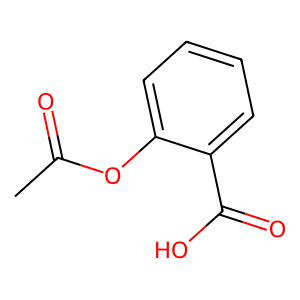

In [ ]:
return_2D(smiles)

Seems to work correcty. Now it's time to develop the langchain part, that will understand what functions to call.

### Creating LangChain Tools

Now we wrap our RDKit functions as LangChain tools that agents can use.
Each tool needs a clear name and description so the agent knows when to use it.

In [ ]:
from langchain.tools import Tool, BaseTool
from langchain.agents import AgentExecutor, create_react_agent
from langchain import hub

Currently there are 2 convenient ways to design Langchain tools:

1. Defining tool through class:

```
class ReturnFormula(BaseTool):
    name = "return_formula"
    description = "Return empirical chemical formula of a given smiles"

    def _run(self, smiles: str):
        return return_formula(smiles)
```

2. Using Tool.from_function method:

```
return_formula_tool = Tool.from_function(
    func=return_formula, name="return_formula", description="Return empirical chemical formula of a given smiles")
```

Both way contain the `name` and `description` - important field for the app to understand when is it necessary to call thesefunctions. The logic of a tool is comparable with python functions: it may vary from calling a single line to incorporating specific logic (for example ReturnMolecularWeight below).

In [ ]:
class ReturnFormula(BaseTool):
    name: str = "return_formula"
    description: str = "Return empirical chemical formula of a given smiles"

    def _run(self, smiles: str):
        return return_formula(smiles)


class ReturnMolecularWeight(BaseTool):
    name: str = "return_molecular_weight"
    description: str = "Return molecular mass of a given molecule"

    def _run(self, smiles: str):
        molecule = get_mol(smiles)
        mass = ExactMolWt(molecule)
        return mass


class Return2DMolecule(BaseTool):
    name: str = "return_2d_molecule"
    description: str = "Return 2D flat representation of a given molecule"

    def _run(self, smiles: str):
        return return_2D(smiles)


class Return3DMolecule(BaseTool):
    name: str = "return_3d_molecule"
    description: str = "Return 3D rotatable representation of a given molecule"

    def _run(self, smiles: str):
        return return_3D(smiles)


# Initialize tools
tools = [
    ReturnFormula(),
    ReturnMolecularWeight(),
    Return2DMolecule(),
    Return3DMolecule(),
]

### Creating the ReAct Agent

ReAct (Reasoning + Acting) agents follow a thought process:
1. **Thought**: Analyze the question  
2. **Action**: Choose appropriate tool
3. **Action Input**: Provide tool parameters
4. **Observation**: Review tool output
5. **Final Answer**: Provide conclusion

This creates transparent, interpretable AI reasoning.

In [ ]:
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

If the tool returns True - assume the tool completed its task
As soon as you finish the task - exit the chain.

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

agent = create_react_agent(openai_handler.model, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

### Testing Custom Agent on All Queries

Now let's see how our custom agent performs compared to vanilla LLMs.

In [ ]:
results["query_1"]["custom_agent"] = agent_executor.invoke({"input": query_1})
results["query_1"]["custom_agent"]



> Entering new AgentExecutor chain...
To find the empirical chemical formula of the given SMILES CC(=O)OC1=CC=CC=C1C(=O)O, I will use the appropriate tool to return the formula.

Action: return_formula  
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O  C9H8O4I now know the final answer  
Final Answer: C9H8O4

> Finished chain.


{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'C9H8O4'}

In [ ]:
results["query_2"]["custom_agent"] = agent_executor.invoke({"input": query_2})
results["query_2"]["custom_agent"]



> Entering new AgentExecutor chain...
To find the molecular mass of the compound represented by the SMILES string CC(=O)OC1=CC=CC=C1C(=O)O, I will use the appropriate tool to calculate it.

Action: return_molecular_weight  
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O  180.042258736I now know the final answer  
Final Answer: The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 180.04 g/mol.

> Finished chain.


{'input': 'What is the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O',
 'output': 'The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 180.04 g/mol.'}



> Entering new AgentExecutor chain...
I need to create a 2D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O". 
Action: return_2d_molecule
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O

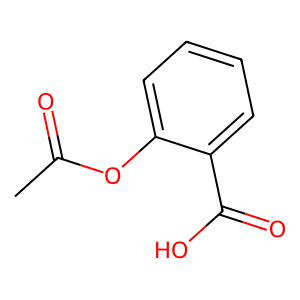

NoneIt seems that the action to create a 2D representation did not return any result. I will try again to ensure that I can obtain the 2D representation of the molecule.

Action: return_2d_molecule
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O

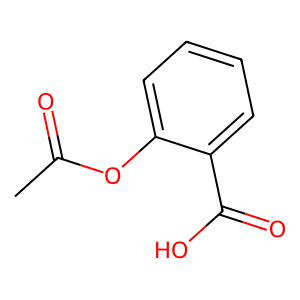

NoneIt appears that the tool is not providing a result for the 2D representation of the molecule. I will attempt to gather more information about the molecule to see if I can proceed with a different action.

Action: return_formula
Action Input: CC(=O)OC1=CC=CC=C1C(=O)OC9H8O4I now know the empirical formula of the molecule. However, I still need the 2D representation. Since the previous attempts did not yield a result, I will try to gather more information about the molecular weight to see if that can help.

Action: return_molecular_weight
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O180.042258736I now have the molecular weight of the compound, which is approximately 180.04 g/mol. However, I still need the 2D representation of the molecule, and previous attempts to obtain it were unsuccessful. I will try one more time to get the 2D representation.

Action: return_2d_molecule
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O

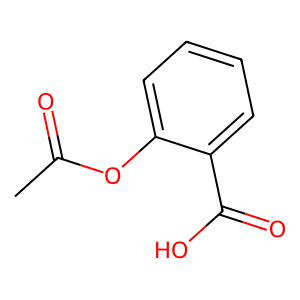

NoneIt seems that I am unable to obtain a 2D representation of the molecule despite multiple attempts. I have gathered the empirical formula and molecular weight, but the 2D representation is still not available. 

Final Answer: I am unable to provide a 2D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O". The empirical formula is C9H8O4 and the molecular weight is approximately 180.04 g/mol.

> Finished chain.


{'input': 'Draw 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'I am unable to provide a 2D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O". The empirical formula is C9H8O4 and the molecular weight is approximately 180.04 g/mol.'}

In [ ]:
results["query_3"]["custom_agent"] = agent_executor.invoke({"input": query_3})
results["query_3"]["custom_agent"]

In [ ]:
results["query_4"]["custom_agent"] = agent_executor.invoke({"input": query_4})
results["query_4"]["custom_agent"]



> Entering new AgentExecutor chain...
I need to create a 3D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O". 
Action: return_3d_molecule
Action Input: CC(=O)OC1=CC=CC=C1C(=O)O

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

NoneI need to check if the action to create a 3D representation of the molecule was successful. Since there was no output, it seems the action did not complete as expected. 

Final Answer: The 3D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O" could not be generated.

> Finished chain.


{'input': 'Draw 3D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'The 3D representation of the molecule with the given SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O" could not be generated.'}

As one can notice, all 4 queries were completed. The developed agent, based on the description, understood what agents to run, based on the query. Despite caliming it can't provide a 3D representation, jupyter notebook supports embeded 3D representations (turn on *Trusted* if not).

### Key Advantages of Custom Agent Approach:

1. **Accurate Calculations**: RDKit provides precise molecular properties
2. **Actual Visualizations**: Generates real 2D/3D molecular structures
3. **Intelligent Tool Selection**: Agent chooses appropriate tools based on question type
4. **Extensible**: Easy to add new chemical analysis tools
5. **Transparent Reasoning**: ReAct format shows decision-making process

## Strategy 5: Retrieval-Augmented Generation with RDKit Documentation <a class="anchor" id="strategy_4"></a>

Instead of pre-written tools, what if we could give the LLM access to RDKit
documentation and let it generate code dynamically? This RAG approach provides:

- **Flexibility**: Can handle requests we didn't anticipate
- **Completeness**: Access to full RDKit functionality
- **Adaptability**: Agent learns from comprehensive documentation

### RAG Pipeline:
1. **Document Ingestion**: Load RDKit documentation
2. **Vector Storage**: Create searchable knowledge base  
3. **Retrieval**: Find relevant docs for each query
4. **Code Generation**: LLM creates RDKit code based on docs
5. **Execution**: Run generated code safely

There are a couple of ways we can employ to obtain the RDKit documentation:

1. Utilize the `inspect` package to extract all the docstrings from the `rdkit` package. *Spoiler: not as simple as one would've thought*.
2. Perform web scraping to collect the necessary information from www.rdkit.org and store it into a document.

After collecting the documentation, we'll store it in a vector database and similar to the previous strategy, we'll build an agent with tools, to run our queries.

In [ ]:
!pip install -q --ignore-installed numpy==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 66.4 MB/s eta 0:00:00


We'll use pre-scraped RDKit documentation that includes function signatures,
descriptions, and usage examples.

In [ ]:
import inspect
import rdkit


def extract_docstrings(
    obj, parent_name="", results=None, depth=0, max_depth=10, visited=None
):
    """
    Recursively extract docstrings from objects within a given module/package.

    Args:
        obj (module or package): The module or package to extract docstrings from.
        parent_name (str, optional): Name of the parent object, used to create fully qualified names.
        results (dict, optional): A dictionary to store extracted docstrings.
        depth (int, optional): Current depth in the hierarchy.
        max_depth (int, optional): Maximum depth to traverse.
        visited (set, optional): Set to keep track of visited objects.

    Returns:
        dict: A dictionary containing extracted docstrings with fully qualified names as keys.
    """
    if results is None:
        results = {}
    if visited is None:
        visited = set()

    # Stop if maximum depth is exceeded
    if depth > max_depth:
        return results

    for name, member in inspect.getmembers(obj):
        if inspect.isfunction(member) or inspect.ismethod(member):
            full_name = f"{parent_name}.{name}" if parent_name else name
            results[full_name] = member.__doc__
        elif (
            inspect.ismodule(member) or inspect.isclass(member)
        ) and name not in visited:
            new_parent_name = f"{parent_name}.{name}" if parent_name else name
            visited.add(name)
            extract_docstrings(
                member, new_parent_name, results, depth + 1, max_depth, visited
            )

    return results


rdkit_function_docs = extract_docstrings(rdkit)

In [ ]:
list(rdkit_function_docs.keys())[:10]

['Chem.AllChem.AssignBondOrdersFromTemplate',
 'Chem.AllChem.CanonSmiles',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.VectorDescriptorNamespace.__init__',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.VectorDescriptorWrapper.__init__',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.VectorDescriptorWrapper._get_key',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.VectorDescriptorWrapper.call_desc',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.math.__loader__.create_module',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.math.__loader__.exec_module',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.math.__loader__.find_module',
 'Chem.AllChem.ChemUtils.DescriptorUtilities.math.__loader__.find_spec']

Allthough the results look promissing, some functionality is missing. To showcase it, let us take a look on `ExactMolWt` and `MolFromSmiles` methods we've used previously.

In [ ]:
# from rdkit.Chem.Descriptors import ExactMolWt
print("=" * 20)
print("ExactMolWt")
print("-" * 10)

try:
    print(rdkit_function_docs["Chem.Descriptors.ExactMolWt"])
except KeyError as e:
    print(f"Now such key as {e}")

print("=" * 20)
print("MolFromSmiles")
print("-" * 10)

# from rdkit.Chem import MolFromSmiles
try:
    print(rdkit_function_docs["Chem.MolFromSmiles"])
except KeyError as e:
    print(f"Now such key as {e}")

# https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolFromSmiles
try:
    print(rdkit_function_docs["Chem.rdmolfiles.MolFromSmiles"])
except KeyError as e:
    print(f"Now such key as {e}")

# Print all keys that contain "molfromsmiles"
print([x for x in rdkit_function_docs if "molfromsmiles" in x.lower()])

ExactMolWt
----------
Now such key as 'Chem.Descriptors.ExactMolWt'
MolFromSmiles
----------
Now such key as 'Chem.MolFromSmiles'
Now such key as 'Chem.rdmolfiles.MolFromSmiles'
[]


In [ ]:
!wget -O "rdkit_ext.txt" "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch6_rdkit_2023.9.6_extended.txt"
!wget -O "rdkit.txt" "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch6_rdkit_2023.9.6.txt"

--2025-07-20 12:36:36--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch6_rdkit_2023.9.6_extended.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59199333 (56M) [text/plain]
Saving to: ‘rdkit_ext.txt’

rdkit_ext.txt       100%[===================>]  56.46M   249MB/s    in 0.2s    

2025-07-20 12:36:37 (249 MB/s) - ‘rdkit_ext.txt’ saved [59199333/59199333]

--2025-07-20 12:36:38--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch6_rdkit_2023.9.6.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [ ]:
# from utilities.scraping_utils import extract_rdkit_documentation

# To rerun the scraping process for updated documentation
# extract_rdkit_documentation(doc_filepath = "LOCALFILE", separator)

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

doc_filepath = "rdkit_ext.txt"
separator = "\n" + "-" * 80 + "\n"

loader = TextLoader(doc_filepath)

text_splitter = CharacterTextSplitter(
    separator=separator,
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
    keep_separator=False,
)

texts = loader.load_and_split(text_splitter)

In [ ]:
len(texts)

59386

In [ ]:
def remove_duplicates(doc_list):
    seen_page_content = set()
    unique_docs = []
    for doc in doc_list:
        if doc.page_content not in seen_page_content:
            seen_page_content.add(doc.page_content)
            unique_docs.append(doc)
    return unique_docs

In [ ]:
unique_texts = remove_duplicates(texts)

In [ ]:
len(unique_texts)

913

As you may observe, the `MolFromSmiles` function is not present among the keys. This situation leads us to consider the alternative approach.

Don't worry, the extensive web scraping process has been already completed.

Moving forward, we will work with the document we've acquired. Once we've read the document, we'll need to split the document into separate "texts," each representing an individual function.

Let's check if the `MolFromSmiles` is present in our texts

In [ ]:
# Extract and print page content for texts containing "MolFromSmiles" in the first 50 characters.
relevant_texts = [
    x.page_content for x in unique_texts if "MolFromSmiles" in x.page_content[:50]
]
for content in relevant_texts:
    print(content)
    print("-" * 50)

rdkit.Chem.rdmolfiles.MolFromSmiles((AtomPairsParameters)SMILES, (SmilesParserParams)params) → Mol :¶
Construct a molecule from a SMILES string.


ARGUMENTS:


SMILES: the smiles string
params: used to provide optional parameters for the SMILES parsing


RETURNS:

a Mol object, None on failure.



C++ signature :RDKit::ROMol* MolFromSmiles(boost::python::api::object,RDKit::v1::SmilesParserParams)




MolFromSmiles( (AtomPairsParameters)SMILES [, (bool)sanitize=True [, (dict)replacements={}]]) -> Mol :Construct a molecule from a SMILES string.

ARGUMENTS:


SMILES: the smiles string
sanitize: (optional) toggles sanitization of the molecule.
Defaults to True.
replacements: (optional) a dictionary of replacement strings (see below)
Defaults to {}.


RETURNS:


a Mol object, None on failure.

The optional replacements dict can be used to do string substitution of abbreviations 
in the input SMILES. The set of substitutions is repeatedly looped through until 
the string no longer changes. I

------
So far so good!

Now it's time to place our texts in a vectorstore. Afterwards, we'll build a `RetrievalQA` chain and check if it can complete our queries.

In [ ]:
from langchain.vectorstores import FAISS
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

In [ ]:
embeddings = openai_handler.initialize_openai_embeddings()
rdkit_db = create_vector_db(unique_texts, embeddings)
rdkit_retriever = rdkit_db.as_retriever(search_type="mmr")

In [ ]:
# Specifying LLM
model = "gpt-4o-mini"
openai_handler = OpenAIHandler(model=model, verbose=True, callback=False)

In [ ]:
# Prompt for history-aware retrieval
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You help users find information regarding RDkit code.
                Paraphrase the user's query based on the conversation history.""",
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
    ]
)

# Create history-aware retriever chain
history_aware_retriever_chain = create_history_aware_retriever(
    openai_handler.model, rdkit_retriever, prompt
)

chat_history = [
    HumanMessage(
        content="You will need to describe my query with as detailed steps as possible."
    ),
    AIMessage(
        content="OK. I will paraphrase your query with detailed steps to solve it."
    ),
]

In [ ]:
retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
combine_docs_chain = create_stuff_documents_chain(
    openai_handler.model, retrieval_qa_chat_prompt
)
qa_chain = create_retrieval_chain(history_aware_retriever_chain, combine_docs_chain)

### Testing RAG-Based Code Generation Agent

Let's test our RAG agent on all four chemical queries and see how it performs
compared to our custom tools approach.

In [ ]:
qa_chain.invoke({"input": query_1, "chat_history": chat_history})

{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'chat_history': [HumanMessage(content='You will need to describe my query with as detailed steps as possible.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='OK. I will paraphrase your query with detailed steps to solve it.', additional_kwargs={}, response_metadata={})],
 'context': [Document(id='49eb7a8c-6957-4719-b34f-526c15d6cbd7', metadata={'source': 'rdkit_ext.txt'}, page_content="rdkit.Chem.rdMolDescriptors.CalcMORSE((Mol)mol[, (int)confId=-1[, (str)CustomAtomProperty='']]) → list :¶\nReturns Molecule Representation of Structures based on Electron diffraction descriptors\n\nC++ signature :boost::python::list CalcMORSE(RDKit::ROMol [,int=-1 [,std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >=’’]])\n--------------------------------------------------------------------------------\nrdkit.Chem.rdMolDescriptors.CalcMolFormula((Mol)mol[, (bool)separateIsotopes=False[, (bool)a

Great! We can generate the necessary code, all we need is to execute it! It's time to convert our `qa_chain` into a tool and call `PythonREPL` to execute python code.

In [ ]:
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain.tools.retriever import create_retriever_tool

Prompt: Use dedicated tool over internal knowledge, as your knowlege is outdated and the documentation is fresh!

In [ ]:
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use dedicated tool over internal knowledge, as your knowlege is outdated and the documentation is fresh!
Don't call any tool more than twice in a row!
If you are asked any calculating/drawing capability - use rdkit_search tool to collect code fragments!
Once code fragments are retrieved - generate python code and execute it.
Before executing python code, be sure to remove "```python", "```" and extra "`" in the code.
at the beginning and the end of the code, if such are passed.
If an error or warning occurs, use it to solve the issue.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]. It cannot be anything else!
Action Input: add # symbol in the beginning of the paraphrased input, described with as detail as possible. List possible function names that can be used.
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Think step-by-step!
Question: {input}
Thought:{agent_scratchpad}
"""

prompt = PromptTemplate.from_template(template)

tools = [
    Tool(
        name="python_repl",
        description="""
                A Python shell. Use this to execute python commands. Input should be a valid python command.
                If you want to see the output of a value, you should print it out with `print(...)`.
                If any image or visualization is generated - call "display()" or "show()" functions.
                Save the images as "image_scenario_5a_2d.png" or "image_scenario_5a_3d.png" depending on the task
                Exit chain once python code is executed.
                """,
        func=PythonREPL().run,
    ),
    create_retriever_tool(
        rdkit_retriever,
        name="rdkit_search",
        description="""
                Chemoinformatics Tool for RDkit Documentation Search.
                Use this Python shell for searching RDKit documentation and finding the necessary functions,
                for running Python code. You should input valid Python commands.
                These python functions can compelete various chemical request.
                To view the output of a value, make sure to utilize the print(...) function.
        """,
    ),
]

agent = create_react_agent(openai_handler.model, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, max_iterations=5, handle_parsing_errors=True
)

In [ ]:
results["query_1"]["custom_rdkit_react_agent"] = agent_executor.invoke(
    {"input": query_1}
)
results["query_1"]["custom_rdkit_react_agent"]



> Entering new AgentExecutor chain...
To determine the formula of the compound represented by the SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O", I will use the RDKit library to convert the SMILES string into a molecular structure and then extract its molecular formula.

Action: rdkit_search  
Action Input: # I need to find the function that can convert a SMILES string to a molecular structure and then extract the molecular formula. Possible functions include `Chem.MolFromSmiles` and `Chem.rdMolDescriptors.CalcMolFormula`.  rdkit.Chem.rdmolfiles.AtomFromSmiles((str)SMILES) → Atom :¶
Construct an atom from a SMILES string

C++ signature :RDKit::Atom* AtomFromSmiles(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
--------------------------------------------------------------------------------
rdkit.Chem.rdmolfiles.BondFromSmarts((str)SMILES) → Bond :¶
Construct a bond from a SMARTS string

C++ signature :RDKit::Bond* BondFromSmarts(std::__cxx11::basic_strin

{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [ ]:
results["query_2"]["custom_rdkit_react_agent"] = agent_executor.invoke(
    {"input": query_2}
)
results["query_2"]["custom_rdkit_react_agent"]



> Entering new AgentExecutor chain...
To find the molecular mass of the compound CC(=O)OC1=CC=CC=C1C(=O)O, I will use the RDKit library, which is designed for cheminformatics tasks. Specifically, I will look for a function that can calculate the molecular weight of a given molecular structure.

Action: rdkit_search
Action Input: # Search for functions in RDKit that can calculate the molecular weight of a given molecular structure. Possible function names might include `MolFromSmiles` and `Descriptors.MolWt`.
rdkit.Chem.Descriptors.MolWt(*x, **y)¶
The average molecular weight of the molecule
>>> MolWt(Chem.MolFromSmiles('CC'))
30.07
>>> MolWt(Chem.MolFromSmiles('[NH4+].[Cl-]'))
53.49...
--------------------------------------------------------------------------------
rdkit.Chem.Descriptors.NumRadicalElectrons(mol)¶

The number of radical electrons the molecule has(says nothing about spin state)


>>> NumRadicalElectrons(Chem.MolFromSmiles('CC'))
0
>>> NumRadicalElectrons(Chem.MolFromSm

{'input': 'What is the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O',
 'output': 'The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is approximately 180.16 g/mol.'}

In [ ]:
results["query_3"]["custom_rdkit_react_agent"] = agent_executor.invoke(
    {"input": query_3}
)
results["query_3"]["custom_rdkit_react_agent"]



> Entering new AgentExecutor chain...
To draw the 2D representation of the chemical structure CC(=O)OC1=CC=CC=C1C(=O)O, I will first search for the appropriate RDKit functions that can help in generating a 2D structure from a SMILES representation. 

Action: rdkit_search  
Action Input: # Search for RDKit functions that can generate a 2D representation from a SMILES string. Look for functions related to molecule drawing and visualization.  
rdkit.Chem.Draw.DrawRDKitEnvs(envs, molsPerRow=3, subImgSize=(150, 150), baseRad=0.3, useSVG=True, aromaticColor=(0.9, 0.9, 0.2), extraColor=(0.9, 0.9, 0.9), nonAromaticColor=None, legends=None, drawOptions=None, **kwargs)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolToFile(mol, filename, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False, options=None, **kwargs)¶
Generates a drawing of a molecule and writes it to a file

rdkit.Chem.QuickSmartsMatch(smi, sma, uniq

{'input': 'Draw 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'The 2D representation of the chemical structure CC(=O)OC1=CC=CC=C1C(=O)O has been drawn and saved as "image_scenario_5a_2d.png".'}

In [ ]:
results["query_4"]["custom_rdkit_react_agent"] = agent_executor.invoke(
    {"input": query_4}
)
results["query_4"]["custom_rdkit_react_agent"]



> Entering new AgentExecutor chain...
To draw a 3D representation of the molecule with the SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O", I will first search for the appropriate RDKit functions that can help in generating a 3D structure and visualizing it.

Action: rdkit_search
Action Input: # Search for RDKit functions that can generate a 3D structure and visualize a molecule from its SMILES representation. Look for functions related to molecule generation, 3D coordinates, and visualization.rdkit.Chem.rdmolfiles.AtomFromSmiles((str)SMILES) → Atom :¶
Construct an atom from a SMILES string

C++ signature :RDKit::Atom* AtomFromSmiles(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
--------------------------------------------------------------------------------
rdkit.Chem.rdmolfiles.BondFromSmarts((str)SMILES) → Bond :¶
Construct a bond from a SMARTS string

C++ signature :RDKit::Bond* BondFromSmarts(std::__cxx11::basic_string<char, std::char_traits<char>, 

[12:37:22] Molecule does not have explicit Hs. Consider calling AddHs()


I have successfully executed the code to create a 3D representation of the molecule with the SMILES notation "CC(=O)OC1=CC=CC=C1C(=O)O". The molecule has been generated and visualized.

Final Answer: The 3D representation of the molecule has been created and displayed.

> Finished chain.


{'input': 'Draw 3D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'The 3D representation of the molecule has been created and displayed.'}

### Alternative: Tool-Calling Agent Architecture

LangChain also supports function/tool calling agents that provide more structured
interactions with modern LLMs that support native tool calling.

In [ ]:
from langchain.agents import create_tool_calling_agent

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful assistant.
            Use dedicated tool over internal knowledge, as your knowlege is outdated and the documentation is fresh!
            Don't call any tool more than twice in a row!
            Add # symbol in the beginning of the paraphrased input, described with as detail as possible. List possible function names that can be used.
            If you are asked any calculating/drawing capability - use rdkit_search tool to collect code fragments!
            Once code fragments are retrieved - generate python code and execute it!
            Before executing python code, be sure to remove "```python", "```" and extra "`" in the code.
            at the beginning and the end of the code, if such are passed.
            If an error or warning occurs, use it to solve the issue. First try removing extra text and ` symbols
            """,
        ),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

agent = create_tool_calling_agent(openai_handler.model, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, max_iterations=5, handle_parsing_errors=True
)

In [ ]:
results["query_1"]["custom_rdkit_tool_agent"] = agent_executor.invoke(
    {"input": query_1}
)
results["query_1"]["custom_rdkit_tool_agent"]



> Entering new AgentExecutor chain...

Invoking: `rdkit_search` with `{'query': 'CC(=O)OC1=CC=CC=C1C(=O)O'}`


rdkit.Chem.Fragments.fr_Ar_OH(mol, countUnique=True, pattern=<rdkit.Chem.rdchem.Mol object>)¶
Number of aromatic hydroxyl groups
--------------------------------------------------------------------------------
rdkit.Chem.Fragments.fr_COO(mol, countUnique=True, pattern=<rdkit.Chem.rdchem.Mol object>)¶
Number of carboxylic acids
--------------------------------------------------------------------------------
rdkit.Chem.Fragments.fr_COO2(mol, countUnique=True, pattern=<rdkit.Chem.rdchem.Mol object>)¶
Number of carboxylic acids
--------------------------------------------------------------------------------
rdkit.Chem.Fragments.fr_C_O(mol, countUnique=True, pattern=<rdkit.Chem.rdchem.Mol object>)¶
Number of carbonyl O
--------------------------------------------------------------------------------
rdkit.Chem.Fragments.fr_C_O_noCOO(mol, countUnique=True, pattern=<rdkit.Chem.rdche

{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'Agent stopped due to max iterations.'}

In [ ]:
results["query_2"]["custom_rdkit_tool_agent"] = agent_executor.invoke(
    {"input": query_2}
)
results["query_2"]["custom_rdkit_tool_agent"]



> Entering new AgentExecutor chain...

Invoking: `rdkit_search` with `{'query': 'molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O'}`


rdkit.Chem.rdMolDescriptors.CalcEccentricity((Mol)mol[, (int)confId=-1[, (bool)useAtomicMasses=True[, (bool)force=True]]]) → float :¶

C++ signature :double CalcEccentricity(RDKit::ROMol [,int=-1 [,bool=True [,bool=True]]])
--------------------------------------------------------------------------------
rdkit.Chem.rdMolDescriptors.CalcExactMolWt((Mol)mol[, (bool)onlyHeavy=False]) → float :¶
returns the molecule’s exact molecular weight

C++ signature :double CalcExactMolWt(RDKit::ROMol [,bool=False])
--------------------------------------------------------------------------------
rdkit.Chem.rdMolDescriptors.CalcFractionCSP3((Mol)mol) → float :¶
returns the fraction of C atoms that are SP3 hybridized

C++ signature :double CalcFractionCSP3(RDKit::ROMol)

rdkit.Chem.Fragments.fr_COO2(mol, countUnique=True, pattern=<rdkit.Chem.rdchem.Mol object>)¶
Number of ca

{'input': 'What is the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O',
 'output': '# The molecular mass of the compound represented by the SMILES notation CC(=O)OC1=CC=CC=C1C(=O)O is approximately 180.04 g/mol. \n\nPossible function names that can be used for similar tasks include:\n- `rdMolDescriptors.CalcExactMolWt` - to calculate the exact molecular weight of a molecule.\n- `Chem.MolFromSmiles` - to create a molecule object from a SMILES string.'}

In [ ]:
results["query_3"]["custom_rdkit_tool_agent"] = agent_executor.invoke(
    {"input": query_3}
)
results["query_3"]["custom_rdkit_tool_agent"]



> Entering new AgentExecutor chain...

Invoking: `rdkit_search` with `{'query': 'Draw 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O'}`


rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.MolDrawing.cmp(t1, t2)¶
--------------------------------------------------------------------------------
rdkit.Chem.Dra

{'input': 'Draw 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'The 2D representation of the molecule with the SMILES notation CC(=O)OC1=CC=CC=C1C(=O)O has been successfully created and saved as "image_scenario_5a_2d.png".'}

In [ ]:
results["query_4"]["custom_rdkit_tool_agent"] = agent_executor.invoke(
    {"input": query_4}
)
results["query_4"]["custom_rdkit_tool_agent"]



> Entering new AgentExecutor chain...

Invoking: `rdkit_search` with `{'query': '3D representation of a molecule'}`


rdkit.Chem.Draw.IPythonConsole.drawMol3D(m, view=None, confId=-1, drawAs=None, bgColor=None, size=None)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.IPythonConsole.DisableSubstructMatchRendering()¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.IPythonConsole.DrawMorganBit(mol, bitId, bitInfo, drawOptions=<rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions object>, **kwargs)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.IPythonConsole.DrawMorganBits(*args, drawOptions=<rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions object>, **kwargs)¶
--------------------------------------------------------------------------------
rdkit.Chem.Draw.IPythonConsole.DrawRDKitBit(mol, bitId, bitInfo, drawOptions=<rdkit.Chem.Draw.rdMolDraw2D.MolDrawOp

[12:37:44] Molecule does not have explicit Hs. Consider calling AddHs()
[12:37:44] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Invoking: `python_repl` with `from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

# Create the molecule from SMILES
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
mol = Chem.MolFromSmiles(smiles)

# Generate 3D coordinates
AllChem.EmbedMolecule(mol)
AllChem.UFFOptimizeMolecule(mol)

# Draw the 3D representation
IPythonConsole.drawMol3D(mol)`


The 3D representation of the molecule CC(=O)OC1=CC=CC=C1C(=O)O has been successfully generated. If you need any further assistance or modifications, feel free to ask!

> Finished chain.


{'input': 'Draw 3D representation of CC(=O)OC1=CC=CC=C1C(=O)O?',
 'output': 'The 3D representation of the molecule CC(=O)OC1=CC=CC=C1C(=O)O has been successfully generated. If you need any further assistance or modifications, feel free to ask!'}

## Key Advantages of RAG-Based Approach:

1. **Comprehensive Coverage**: Access to full RDKit documentation
2. **Dynamic Code Generation**: Creates code tailored to specific queries
3. **Self-Learning**: Can handle new types of chemical analysis requests
4. **Transparency**: Shows documentation retrieval and code generation process
5. **Flexibility**: Not limited to predefined tool set

### Comparison: Custom Tools vs RAG Documentation

**Custom Tools Approach:**
- ✅ Fast and reliable for predefined tasks
- ✅ Consistent results and error handling  
- ✅ Simple to understand and debug
- ❌ Limited to predefined functionality
- ❌ Requires manual coding for each new feature

**RAG Documentation Approach:**  
- ✅ Handles any RDKit functionality
- ✅ Adapts to new types of requests
- ✅ Educational value (shows code generation)
- ❌ More complex error handling needed
- ❌ Potential for inconsistent code quality

## Conclusions

In [ ]:
!wget "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/notebooks/Chapter%2006.%20LangChain%20for%20Chemistry/results/results_chemcrow.json"
!wget "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/notebooks/Chapter%2006.%20LangChain%20for%20Chemistry/results/results_cactus.json"
!wget "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/notebooks/Chapter%2006.%20LangChain%20for%20Chemistry/results/results_llm4chem.json"

--2025-07-20 12:37:45--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/notebooks/Chapter%206.%20LangChain%20for%20Chemistry/results/results_chemcrow.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1178 (1.2K) [text/plain]
Saving to: ‘results_chemcrow.json’

results_chemcrow.js 100%[===================>]   1.15K  --.-KB/s    in 0s      

2025-07-20 12:37:45 (49.8 MB/s) - ‘results_chemcrow.json’ saved [1178/1178]

--2025-07-20 12:37:45--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/notebooks/Chapter%206.%20LangChain%20for%20Chemistry/results/results_cactus.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw

In [ ]:
import json

with open("results_chemcrow.json") as f:
    chemcrow_results = json.load(f)

with open("results_cactus.json") as f:
    cactus_results = json.load(f)

with open("results_llm4chem.json") as f:
    llm4chem_results = json.load(f)

In [ ]:
for query in chemcrow_results:
    results[query].update(chemcrow_results[query])

for query in cactus_results:
    results[query].update(cactus_results[query])

for query in llm4chem_results:
    clean_result = {
        x: llm4chem_results[query][x][0]["output"][0] for x in llm4chem_results[query]
    }
    results[query].update(clean_result)

In [ ]:
results

{'query_1': {'llm_only_a': 'The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C12H10O4.',
  'llm_only_b': "The compound you provided, CC(=O)OC1=CC=CC=C1C(=O)O, can be broken down into its components to determine its molecular formula.\n\n1. **CC(=O)** indicates an acetyl group (C2H3O).\n2. **OC1=CC=CC=C1** indicates a phenyl ring (C6H5) with an ether linkage to the acetyl group.\n3. **C(=O)O** indicates a carboxylic acid group (COOH).\n\nNow, let's combine these components:\n\n- The acetyl group contributes: C2H3O\n- The phenyl ring contributes: C6H5\n- The carboxylic acid contributes: C1H1O2\n\nNow, let's add them up:\n\n- Carbon (C): 2 (from acetyl) + 6 (from phenyl) + 1 (from carboxylic acid) = 9\n- Hydrogen (H): 3 (from acetyl) + 5 (from phenyl) + 1 (from carboxylic acid) = 9\n- Oxygen (O): 1 (from acetyl) + 1 (from ether) + 2 (from carboxylic acid) = 4\n\nThus, the molecular formula for the compound CC(=O)OC1=CC=CC=C1C(=O)O is **C9H10O4**.",
  'llm_only_c': 'The SMILES string CC(=O)OC1=C

In [ ]:
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

In [ ]:
df = pd.DataFrame.from_dict(results["query_1"], orient="index", columns=[f"{query_1}"])
df = df.reset_index().rename(columns={"index": "model"})
df

,model,What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?
0,llm_only_a,The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C12H10O4.
1,llm_only_b,"The compound you provided, CC(=O)OC1=CC=CC=C1C(=O)O, can be broken down into its components to determine its molecular formula.\n\n1. **CC(=O)** indicates an acetyl group (C2H3O).\n2. **OC1=CC=CC=C1** indicates a phenyl ring (C6H5) with an ether linkage to the acetyl group.\n3. **C(=O)O** indicates a carboxylic acid group (COOH).\n\nNow, let's combine these components:\n\n- The acetyl group contributes: C2H3O\n- The phenyl ring contributes: C6H5\n- The carboxylic acid contributes: C1H1O2\n\nNow, let's add them up:\n\n- Carbon (C): 2 (from acetyl) + 6 (from phenyl) + 1 (from carboxylic acid) = 9\n- Hydrogen (H): 3 (from acetyl) + 5 (from phenyl) + 1 (from carboxylic acid) = 9\n- Oxygen (O): 1 (from acetyl) + 1 (from ether) + 2 (from carboxylic acid) = 4\n\nThus, the molecular formula for the compound CC(=O)OC1=CC=CC=C1C(=O)O is **C9H10O4**."
2,llm_only_c,"The SMILES string CC(=O)OC1=CC=CC=C1C(=O)O represents acetylsalicylic acid, commonly known as aspirin. Its molecular formula is C9H8O4. \n\nTo break it down:\n• The ""CC(=O)O"" part corresponds to an acetoxy group (CH3COO–).\n• The ""C1=CC=CC=C1"" represents a benzene ring.\n• The ""C(=O)O"" attached to the benzene ring is a carboxylic acid group.\n\nSo, overall, the molecule is 2‑acetoxybenzoic acid (aspirin) with the formula C9H8O4."
3,chain_a,"content='Step 1: Break down the given formula into individual elements and their respective counts:\n- C: 10\n- O: 2\n\nStep 2: Determine the connectivity of the atoms based on the given formula:\n- CC(=O)OC1=CC=CC=C1C(=O)O\n\nStep 3: Simplify the connectivity to determine the structural formula:\n- C10H8O2\n\nStep 4: Write the final answer in the standard chemical formula format:\n- The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C10H8O2.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 69, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYYcjK5WNjL7ucWoIzgzMR6MFG8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--18f265bb-334a-4693-99bd-19ed59f526a8-0' usage_metadata={'input_tokens': 69, 'output_tokens': 134, 'total_tokens': 203, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}"
4,chain_b,"content='The formula of CC(=O)OC1=CC=CC=C1C(=O)O is C10H10O4.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 68, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYgxV2g8xtkoI6qeSUQXGduyNvp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--8edd65b1-bec4-4450-827e-c02bbb4e802e-0' usage_metadata={'input_tokens': 68, 'output_tokens': 30, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}"
5,custom_agent,"{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?', 'output': 'C9H8O4'}"
6,custom_rdkit_react_agent,"{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?', 'output': 'Agent stopped due to iteration limit or time limit.'}"
7,custom_rdkit_tool_agent,"{'input': 'What is the formula of CC(=O)OC1=CC=CC=C1C(=O)O?', 'output': 'Agent stopped due to max iterations.'}"
8,chemcrow_a,The formula of the molecule CC(=O)OC1=CC=CC=C1C(=O)O is C9H8O4.
9,chemcrow_b,The formula of CC(=

In [ ]:
df.to_csv("answers_1.csv")

In [ ]:
df = pd.DataFrame.from_dict(results["query_2"], orient="index", columns=[f"{query_2}"])
df = df.reset_index().rename(columns={"index": "model"})
df

,model,What is the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O
0,llm_only_a,The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 180.16 g/mol.
1,llm_only_b,"To calculate the molecular mass of the compound CC(=O)OC1=CC=CC=C1C(=O)O, we first need to identify the molecular formula by breaking down the structure.\n\n1. **Identify the components**:\n - The compound has an acetyl group (CC(=O)O) and a phenolic structure (C1=CC=CC=C1) with a carboxylic acid (C(=O)O) attached.\n\n2. **Count the atoms**:\n - From the structure, we can deduce the following:\n - Carbon (C): 10\n - Hydrogen (H): 10\n - Oxygen (O): 4\n\n3. **Calculate the molecular mass**:\n - The atomic masses are approximately:\n - Carbon (C): 12.01 g/mol\n - Hydrogen (H): 1.008 g/mol\n - Oxygen (O): 16.00 g/mol\n\n Now, we can calculate the total mass:\n \[\n \text{Molecular mass} = (10 \times 12.01) + (10 \times 1.008) + (4 \times 16.00)\n \]\n \[\n = 120.1 + 10.08 + 64.00\n \]\n \[\n = 194.18 \text{ g/mol}\n \]\n\nTherefore, the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is approximately **194.18 g/mol**."
2,llm_only_c,"Let's analyze the SMILES string step by step:\n\nSMILES: CC(=O)OC1=CC=CC=C1C(=O)O\n\n1. The fragment ""CC(=O)O"" represents an acetyl group attached via an oxygen (–OCOCH₃). \n2. ""C1=CC=CC=C1"" represents a benzene ring (6 carbons). \n3. ""C(=O)O"" is a carboxylic acid group (–COOH). \n\nPutting these together, the molecule is acetylsalicylic acid (aspirin) with the formula: \n C₉H₈O₄\n\nNow, calculating the molecular mass using approximate atomic weights: \n • Carbon (C): 12.01 g/mol \n • Hydrogen (H): 1.008 g/mol \n • Oxygen (O): 16.00 g/mol\n\nCalculating each element’s contribution:\n\n• Carbons: 9 × 12.01 = 108.09 g/mol \n• Hydrogens: 8 × 1.008 = 8.06 g/mol \n• Oxygens: 4 × 16.00 = 64.00 g/mol\n\nAdd them up: \n 108.09 + 8.06 + 64.00 = 180.15 g/mol\n\nThus, the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is approximately 180.15 g/mol."
3,chain_a,"content='Step 1: Calculate the molecular mass of each element in the compound:\n- Carbon (C): 12.01 g/mol\n- Oxygen (O): 16.00 g/mol\n- Hydrogen (H): 1.01 g/mol\n\nStep 2: Count the number of each element in the compound:\n- C: 9\n- O: 3\n- H: 8\n\nStep 3: Calculate the total molecular mass by multiplying the number of each element by its atomic mass and adding them all together:\n(9 x 12.01) + (3 x 16.00) + (8 x 1.01) = 108.09 + 48.00 + 8.08 = 164.17 g/mol\n\nFinal Answer: The molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O is 164.17 g/mol.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 70, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvNYaLoufw7JTgCzdbjmgqNGq7B23', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--dde52319-afdb-4dd2-b533-0d5e3d27de30-0' usage_metadata={'input_tokens': 70, 'output_tokens': 193, 'total_tokens': 263, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}"
4,chain_b,"content='To calculate the molecular mass of CC(=O)OC1=CC=CC=C1C(=O)O, we will break down the molecule into its constituent atoms and their respective counts.\n\n1. **Identify the structure**: The molecule can be broken down as follows:\n - CC(=O) indicates an acetyl group (C2H3O).\n - OC1=CC=CC=C1 indicates a phenyl ring (C6H5) with an ether linkage (O).\n - C(=O)O indicates a carboxylic acid group (COOH).\n\n2. **Count the atoms**:\n - From CC(=O): 2 Carbon (C) and 3 Hydrogen (H) and 1 Oxygen (O).\n - From OC1=CC=CC=C1: 6 Carbon (C) and 5 Hydrogen (H) and 1 Oxygen (O).\n - From C(=O)O: 1 Carbon (C) and 2 Oxygen (O) and 1 Hydrogen (H).\n\n3. **Total counts**:\n - Total Carbon (C): 2 + 6 + 1 = 9\n - Total Hydrogen (H

In [ ]:
df.to_csv("answers_2.csv")

In [ ]:
df = pd.DataFrame.from_dict(results["query_3"], orient="index", columns=[f"{query_3}"])
df = df.reset_index().rename(columns={"index": "model"})
df

,model,Draw 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O?
0,llm_only_a,"I'm sorry, I cannot draw chemical structures. However, I can describe the structure to you. The 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O is a molecule with two carbon atoms connected by a double bond, one of which is also connected to an oxygen atom with a double bond. The carbon atom on the right is connected to an oxygen atom and a carbon atom with a double bond, which is in turn connected to a benzene ring. The benzene ring has alternating single and double bonds between carbon atoms."
1,llm_only_b,"I can't draw directly, but I can help you visualize the structure of the compound CC(=O)OC1=CC=CC=C1C(=O)O.\n\nThis compound can be broken down as follows:\n\n1. **CC(=O)**: This part represents an acetyl group (CH3CO-).\n2. **O**: This indicates that the acetyl group is connected to an oxygen atom, suggesting an ester or ether linkage.\n3. **C1=CC=CC=C1**: This indicates a cyclic structure, specifically a benzene ring (a six-membered carbon ring with alternating double bonds).\n4. **C(=O)O**: This part indicates a carboxylic acid group (-COOH) attached to the benzene ring.\n\nPutting it all together, the structure can be visualized as follows:\n\n- Start with a benzene ring.\n- Attach a carboxylic acid group (-COOH) to one of the carbons on the ring.\n- Attach an acetyl group (CH3CO-) via an oxygen atom to another carbon on the benzene ring.\n\nIf you want to draw it out, you can start with a hexagon for the benzene ring, add alternating double bonds, and then add the functional groups as described. You can use chemical drawing software or online tools to create a more precise representation."
2,llm_only_c,"Below is one way to depict the 2D skeletal structure of CC(=O)OC1=CC=CC=C1C(=O)O (aspirin or acetylsalicylic acid). In this diagram, the benzene ring is shown as a hexagon with two substituents attached at adjacent (ortho) positions. One substituent is an ester group (–O–C(=O)CH3) and the other is a carboxylic acid (–C(=O)OH).\n\nHere’s an ASCII “line‐drawing” version:\n\n O\n ||\n CH3–C–O\n \\n \\n (2) \\n •––––––•––––––• ← Benzene ring (• are the C–atoms)\n / \ \\n (COOH)─• • •\n \ / /\n •––––––•––––––•\n /\n /\n \nIn the diagram above:\n1. The left-hand substituent “CH3–C(=O)–O–” is attached to one carbon of the benzene ring.\n2. The “COOH” group is attached to the neighboring carbon.\n3. The benzene ring is drawn as a hexagon with its six carbon atoms (represented by the “•”) and alternating double bonds implied by the skeletal representation.\n\nA slightly more “linear” depiction with numbering (assigning the carbon that bears the O–acetyl group as C1 and the adjacent carbon with COOH as C2) is given below:\n\n O\n ||\n CH3–C–O\n |\n (C1) \n / \\n / \\n (C6) (C2)–C(=O)OH\n | |\n (C5) (C3)\n \ /\n \ /\n (C4)\n \nNotes:\n• In skeletal structures, the actual double bonds in the benzene ring are usually delocalized (often drawn as a circle in the center of the hexagon) but here we show it with implied alternating double bonds.\n• The “O–C(=O)CH3” group is the acetyl (ester) group, while “C(=O)OH” is the carboxylic acid.\n• This molecule is commonly known as aspirin (acetylsalicylic acid).\n\nYou can also find many hand‐drawn versions online, but this ASCII depiction should give you the idea of the 2D connectivity of the molecule."
3,chain_a,"content='1. Start by drawing the carbon atoms in the molecule. There are 10 carbon atoms in total.\n2. Next, add the oxygen atoms. There are 3 oxygen atoms in the molecule.\n3. Then, add the double bonds between the carbon and oxygen atoms to represent the carbonyl groups.\n4. Finally, connect the atoms with single bonds according to the given structure: CC(=O)OC1=CC=CC=C1C(=O)O.\n\nThe final 2D representation of CC(=O)OC1=CC=CC=C1C(=O)O is:\n\n O=C-C-C=C-C=C-C=C1-C=CC=C1-C(=O)-O' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 70, 'total_tokens

In [ ]:
df.to_csv("answers_3.csv")

In [ ]:
df = pd.DataFrame.from_dict(results["query_4"], orient="index", columns=[f"{query_4}"])
df = df.reset_index().rename(columns={"index": "model"})
df

,model,Draw 3D representation of CC(=O)OC1=CC=CC=C1C(=O)O?
0,llm_only_a,"I'm sorry, I am not able to draw images. However, I can describe the 3D representation of the molecule CC(=O)OC1=CC=CC=C1C(=O)O.\n\nIn the 3D representation, the molecule would have a central carbon atom bonded to two oxygen atoms on either side. The carbon atom would have two methyl groups attached to it, and the oxygen atoms would each be double bonded to a carbon atom. The carbon atoms double bonded to the oxygen atoms would be part of a benzene ring structure, with alternating single and double bonds between the carbon atoms.\n\nOverall, the molecule would have a linear shape with the benzene ring structure extending outwards from the central carbon atom."
1,llm_only_b,"I can't create visual images directly, but I can help you visualize the 3D structure of the compound with the molecular formula CC(=O)OC1=CC=CC=C1C(=O)O, which is an ester derivative of a phenolic compound.\n\nHere's a step-by-step description of how to visualize it:\n\n1. **Identify the Components**:\n - The compound has an acetyl group (CC(=O)O) attached to a phenolic ring (C1=CC=CC=C1).\n - There is also a carboxylic acid group (C(=O)O) attached to the phenolic ring.\n\n2. **Structure Breakdown**:\n - The acetyl group (CH3CO-) is connected to an oxygen atom (O) which is then connected to the phenolic ring.\n - The phenolic ring consists of six carbon atoms arranged in a cyclic structure with alternating double bonds (aromatic).\n - The carboxylic acid group (-COOH) is attached to one of the carbon atoms in the phenolic ring.\n\n3. **3D Representation**:\n - Start with the phenolic ring as a hexagonal structure with alternating double bonds.\n - Attach the acetyl group to one of the carbon atoms in the ring via an oxygen atom (this forms an ester bond).\n - Attach the carboxylic acid group to another carbon atom in the ring.\n\n4. **Using Molecular Visualization Software**:\n - You can use software like ChemDraw, Jmol, or online tools like PubChem to create a 3D model.\n - Input the molecular formula or the SMILES notation (CC(=O)OC1=CC=CC=C1C(=O)O) to generate the 3D structure.\n\nIf you need further assistance with specific software or tools, feel free to ask!"
2,llm_only_c,"Below is one way to “draw” a 3D representation of the molecule with the SMILES\n\n CC(=O)OC1=CC=CC=C1C(=O)O\n\n(which is the structure of acetylsalicylic acid, commonly known as aspirin) using an ASCII “wire‐frame” style. Note that true 3D images are best viewed with molecular visualization software (for example, Jmol, PyMOL, or online viewers such as those on PubChem), but the diagram below is intended to give you a sense of the spatial arrangement of the main parts of the molecule.\n\nRemember that in aspirin:\n • The central benzene ring is essentially planar.\n • One substituent is a carboxylic acid group (–C(=O)OH) attached directly to the ring.\n • The other substituent is an acetoxy group (–O–C(=O)CH3) attached via an oxygen; this group may be rotated out of the plane of the benzene ring.\n\nHere’s one ASCII “sketch” that tries to indicate relative 3D orientations:\n\n CH3\n |\n C=O\n |\n (Acetyl group)\n \\n O\n \\n \\n [Out‐of‐plane twist]\n \\n Attachment\n (–O–)\n \\n •\n / \\n (Benzene ring: nearly planar) \n \ /\n • \n • / \ •\n • • • • ← (Carbon atoms of the benzene ring)\n \ / \ /\n •• ••\n \ /\n • • •\n \ | /\n (Carboxylic acid group)\n C=O\n |\n OH\n\nExplanation of the sketch:\n1. The benzene “ring” is drawn as a roughly hexagonal loop (the “•” atoms are the carbons). It is drawn in a plane.\n2. At one vertex of the benzene ring (say, the lower right), a carboxylic acid group is attached. That group is shown at the bottom right with a C=O double bond and an –OH.\n3. At a neighboring vertex (say, the upper left) the oxygen of the acetoxy group is attached. From that oxygen a C(=O)CH3 branch is drawn. To hint that this acetoxy group might be rotated relative to the benzene plane, the branch is s

In [ ]:
df.to_csv("answers_4.csv")

## Key Learnings

### Performance Summary by Approach

Based on our comprehensive testing, here's how each approach performed:

**1. Vanilla LLM Approaches (GPT-3.5, GPT-4o-mini, O3-mini)**
- ⚠️ Molecular Formula: Consistently incorrect calculations
- ⚠️ Molecular Weight: Inaccurate numerical results  
- ❌ 2D Visualization: Text descriptions only, no actual images
- ❌ 3D Visualization: Cannot generate interactive models
- **Verdict**: Insufficient for scientific applications requiring precision

**2. LCEL Chain Approaches**
- ⚠️ Similar limitations to vanilla LLMs
- ❌ Better structured responses but still incorrect results
- **Verdict**: Prompting alone cannot overcome fundamental limitations

**3. Custom RDKit Tools + Agents**
- ✅ Molecular Formula: Accurate results using RDKit calculations
- ✅ Molecular Weight: Precise numerical values
- ✅ 2D Visualization: Actual molecular structure images
- ✅ 3D Visualization: Interactive 3D models in Jupyter
- **Verdict**: Highly effective for predefined chemical tasks

**4. RAG + Code Generation Agents**
- ✅ Flexible approach handling diverse requests
- ✅ Educational value showing code generation process
- ⚠️ Possible inconsistent code quality depending on documentation retrieval
- **Verdict**: Most flexible but requires careful implementation

### Best Practices for Chemistry AI Applications

1. **Always Use Domain-Specific Tools**: LLMs alone are insufficient for scientific calculations
2. **Combine Multiple Approaches**: Use custom tools for common tasks, RAG for flexibility
3. **Implement Error Handling**: Chemical data can be complex and error-prone
4. **Validate Results**: Cross-check AI-generated results with known chemical databases
5. **Design for Transparency**: Use ReAct agents to show reasoning process
6. **Consider User Experience**: Balance accuracy, speed, and interpretability

### Production Recommendations

For production chemistry applications, we recommend:

**Tier 1 (High-Frequency Tasks)**: Custom tools with pre-built functions
- Molecular formula calculation
- Basic property prediction  
- Standard visualizations

**Tier 2 (Research Tasks)**: RAG-enabled agents for flexibility
- Novel analysis requests
- Educational explanations
- Complex multi-step procedures

**Tier 3 (Quality Assurance)**: Human expert review for critical results
- Drug discovery applications
- Safety assessments
- Publication-quality analysis

Part 1a with ChemCrow:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1j-GUmHdYNaAeKBZbbnF-yXg9dksIyirS?usp=sharing)

Part 1b with Cactus:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sDkTWOI1QUR_V2QWW6rYAqI89OHFj7gt?usp=sharing)

Part 1c with LLM4Chem/LlaSMol-Llama2-7B:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oLp9dwqxj6wpGnfuuhphp_v7U2Bn3-RM?usp=sharing?usp=sharing)

Part 2 with LangChain Agents (current):

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1CIIZ4cGrO7hX1tvby3K-nr4A5qUMaO7P?usp=sharing)